# MILP/MINLP Formulation of Active Fund Manager assessment

The following is a Jupyter notebook implementation of S Balan's work 'MILP and MINLP Formulation for Active fund performance analysis'

In [1]:
import yfinance as yf
import pandas as pd
import requests
from bs4 import BeautifulSoup
from gamspy import Container, Set, Parameter, Variable, Equation, Model, Sum, Sense, Options
import numpy as np
import sys
import gamspy as gp
import math
import matplotlib.pyplot as plt
import pickle
import yfinance


## Loading price data

The following code loads and prepares a price array from a list of Russell 1000 stocks. 

In [121]:
# Load the data
price_df = pd.read_csv('russell_1000_stock_prices_2024.csv')

# Extract the tickers (first column) as a numpy array
tickers = price_df.iloc[:, 0].to_numpy()


# Set the first column (tickers) as the index
price_df.set_index(price_df.columns[0], inplace=True)

# Convert column names to datetime, stripping timezone information
price_df.columns = pd.to_datetime(price_df.columns.str.replace(r'-\d{2}:\d{2}$', '', regex=True))

# Transpose the DataFrame to make dates the index
price_df = price_df.T

# Resample the data to weekly frequency, taking the mean of each week
weekly_price_df = price_df.resample('M').mean()

# Transpose back to get stocks as rows and weeks as columns
weekly_price_df = weekly_price_df.T

# Convert the weekly price DataFrame to a numpy array
weekly_price_array = weekly_price_df.to_numpy()

# # Regularize the weekly prices: divide each row by its first value
# regularized_weekly_price_df = weekly_price_df.div(weekly_price_df.iloc[:, 0], axis=0)

# # Convert the regularized weekly price DataFrame to a numpy array
# regularized_weekly_price_array = regularized_weekly_price_df.to_numpy()

price_array = weekly_price_array


rows_with_nan_or_zero = np.isnan(price_array).any(axis=1) | (price_array == 0).any(axis=1)  # Identify rows with NaN or zero
price_array = price_array[~rows_with_nan_or_zero]  # Keep only rows without NaN or zero
tickers = tickers[~rows_with_nan_or_zero]  # Update tickers to match the filtered price_array

C:\Users\Sarang Sujit\AppData\Local\Temp\ipykernel_21596\3411554464.py:18: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  weekly_price_df = price_df.resample('M').mean()


In [122]:
price_array.shape

(980, 12)

In [123]:
price_array

array([[130.48602985, 132.61631776, 145.24767381, ..., 138.67281376,
        133.86107673, 137.53927766],
       [ 29.74858447,  26.9610137 ,  30.07714682, ...,  40.36465272,
         44.21899986,  40.32650013],
       [ 13.97761899,  14.92799997,  14.64299998, ...,  12.39304343,
         14.11300006,  16.76399989],
       ...,
       [121.11742365, 124.56176415, 126.02851944, ..., 104.3998005 ,
        109.75197182, 107.50738678],
       [252.60047622, 262.26399918, 288.77350005, ..., 371.40304033,
        393.76800079, 399.53650358],
       [ 53.58000001,  53.65900002,  51.35950012, ...,  59.70956487,
         71.99500008,  76.39149971]])

## Model

In [162]:
# Portfolio Configuration Parameters
max_exposure = 0.05  # Maximum exposure per stock
buy_exposure = 0.03 # Maximum buying limit as a fraction of NAV
max_return = 1.50  # Cap on maximum return per stock
PT = 2.80  # Portfolio turnover rate
cash_min = 0.01  # Minimum cash position as a fraction of NAV
cash_max = 0.05 
bfee = 1.01  # Buy fee multiplier
sfee = 0.99  # Sell fee multiplier
expected_return = 1.40# Target return for the portfolio
init_cash = 1000000  # Initial cash balance
eps = 0.0000001  # Small constant for numerical stability
M = 100000000  # Large constant for big-M method

# Define the model container
m = Container()

# Sets
time_index = 12  # Total number of time periods
stocks = Set(container=m, name="stocks", records=tickers)  # Set of stocks
time = Set(container=m, name="time", records=np.arange(0, time_index, 1))  # Time periods
subtime = Set(container=m, domain=time, records=np.arange(1, time_index, 1))  # Excludes first period
subtime2 = Set(container=m, domain=time, records=np.arange(2, time_index, 1))  # Excludes first two periods

# Data: Stock prices indexed by stocks and time
prices = Parameter(
    container=m,
    name="prices",
    domain=[stocks, time],
    records=price_array,
)

# Variables
C = Variable(container=m, name="C", domain=time, type="Positive")  # Cash balance
V = Variable(container=m, name="V", domain=time, type="Positive")  # Net Asset Value
x = Variable(container=m, name="x", domain=[stocks, time], type="Positive")  # Holdings
x.fx[stocks, '0'] = 0  # No initial holdings

b = Variable(container=m, name="b", domain=[stocks, time], type="Positive")  # Stocks bought
bp = Variable(container=m, name="bp", domain=[stocks, time], type="SemiCont")  # Stocks bought value
sp = Variable(container=m, name="sp", domain=[stocks, time], type="Positive")  # Stocks sold value
b.fx[stocks, '0'] = 0  # No initial buying
bp.lo[stocks, time] = 5000
bp.up[stocks, time] = 100000

s = Variable(container=m, name="s", domain=[stocks, time], type="Positive")  # Stocks sold
Z = Variable(container=m, name="Z", type="free")  # Objective variable
Sr = Variable(container=m, name="Sr", domain=[stocks], type="Positive")  # Total sales
Br = Variable(container=m, name="Br", domain=[stocks], type="Positive")  # Total purchases

gamma_s = Variable(container=m, name="gs", domain=[stocks, time], type="Binary")  # Sell indicator
gamma_b = Variable(container=m, name="gb", domain=[stocks, time], type="Binary")  # Buy indicator

profit = Variable(container=m, name="profit", domain=[stocks], type="Free")  # Profit per stock
omega = Variable(container=m, name="omega", domain=[stocks], type="Binary")  # Binary variable if stock is a winner
omega_trades = Variable(container=m, name="omega_trades", domain=[stocks], type="Binary")  # Binary variable if stock was traded


# Equations
buy_or_sell = Equation(
    m,
    name="buy_or_sell",
    domain=[stocks, time],
    description="Ensures a stock is either bought or sold at time t, but not both"
)
buy_or_sell[stocks, time] = (1 >= gamma_s[stocks, time] + gamma_b[stocks, time])

omega_trades_determination = Equation(
    m,
    name="omega_trades_determination",
    domain=[stocks],
    description="Sets omega_trades to 1 if stock was traded (Br[stocks] > 0)"
)
omega_trades_determination[stocks] = (
    Sum(time, bp[stocks, time]) <= M * omega_trades[stocks]
)

omega_trades_determination2 = Equation(
    m,
    name="omega_trades_determination2",
    domain=[stocks],
    description="Ensures omega_trades is 1 if stock was traded (Br[stocks] > 0)"
)
omega_trades_determination2[stocks] = (
    Sum(time, bp[stocks, time]) >= 10 * omega_trades[stocks]
)

buy_limit = Equation(
    m,
    name="buy_limit",
    domain=[stocks, time],
    description="Activates gamma_b if stock is bought at time t"
)
buy_limit[stocks, time] = b[stocks, time] <= M * gamma_b[stocks, time]

sell_limit = Equation(
    m,
    name="sell_limit",
    domain=[stocks, time],
    description="Activates gamma_s if stock is sold at time t"
)
sell_limit[stocks, time] = s[stocks, time] <= M * gamma_s[stocks, time]

stocks_bought_value = Equation(
    m,
    name="stocks_bought_value",
    domain=[stocks, time],
    description="Calculates the value of stocks bought at time t"
)
stocks_bought_value[stocks, time] = (bp[stocks, time] == b[stocks, time] * prices[stocks, time])

stocks_sold_value = Equation(
    m,
    name="stocks_sold_value",
    domain=[stocks, time],
    description="Calculates the value of stocks sold at time t"
)
stocks_sold_value[stocks, time] = (sp[stocks, time] == s[stocks, time] * prices[stocks, time])

# Winner determination
# Winner determination
winner_determination = Equation(
    m,
    name="winner_determination",
    domain=[stocks],
    description="Sets omega to 1 if stock was a winner (profit > 0)"
)
winner_determination[stocks] = (
    profit[stocks] >= 10 * omega[stocks] - M * (1 - omega[stocks])
)

# Loser determination
loser_determination = Equation(
    m,
    name="loser_determination",
    domain=[stocks],
    description="Sets omega to 0 if stock was a loser (profit <= 0)"
)
loser_determination[stocks] = (
    profit[stocks] <= M * omega[stocks]
)

total_sales = Equation(
    m,
    name="total_sales",
    domain=[stocks],
    description="Calculates total revenue from selling stock"
)
total_sales[stocks] = (Sr[stocks] == Sum(time, prices[stocks, time] * s[stocks, time]))

total_purchases = Equation(
    m,
    name="total_purchases",
    domain=[stocks],
    description="Calculates total cost from buying stock"
)
total_purchases[stocks] = (Br[stocks] == Sum(time, prices[stocks, time] * b[stocks, time]))

pnl = Equation(
    m,
    name="pnl",
    domain=[stocks],
    description="Calculates profit for each stock"
)
pnl[stocks] = (
    profit[stocks] == 
    (Sr[stocks] + x[stocks, str(time_index - 1)] * prices[stocks, str(time_index - 1)]) - Br[stocks]
)

# portfolio_turnover = Equation(
#     m,
#     name="portfolio_turnover",
#     description="Calculates portfolio turnover"
# )
# portfolio_turnover[...] = (
#     PT * (V["1"] + V[str(time_index-1)]) <= 
#     Sum(stocks, Sum(subtime2, b[stocks, subtime2] * prices[stocks, subtime2])) * 2
# )

max_returns = Equation(
    m,
    name="max_returns",
    domain=[stocks],
    description="Caps maximum returns per stock"
)
max_returns[stocks] = (
    (Sr[stocks] + x[stocks, str(time_index - 1)] * prices[stocks, str(time_index - 1)]) <= 
    Br[stocks] * max_return
)

holdings_balance = Equation(
    m,
    name="holdings_balance",
    domain=[stocks, time],
    description="Tracks holdings balance over time"
)
holdings_balance[stocks, subtime] = (
    x[stocks, subtime] == x[stocks, subtime - 1] + b[stocks, subtime] - s[stocks, subtime]
)

holdings_balance_initial = Equation(
    m,
    name="holdings_balance_initial",
    domain=[stocks],
    description="Initial stock holdings"
)
holdings_balance_initial[stocks] = (x[stocks, "0"] == 0)


cash_constraint1 = Equation(
    m,
    name="cash_constraint1",
    domain=[time],
    description="Ensures minimum cash balance"
)
cash_constraint1[time] = (
    C[time] >= cash_min * V[time]
)




cash_constraint2 = Equation(
    m,
    name="cash_constraint2",
    domain=[subtime],
    description="Ensures maximum cash balance"
)
cash_constraint2[subtime] = (
    C[subtime] <= cash_max * V[subtime]
)





cash_balance = Equation(
    m,
    name="cash_balance",
    domain=[time],
    description="Tracks cash balance at each time period"
)
cash_balance[time] = (
    C[time] == C[time - 1] - 
    Sum(stocks, bfee * bp[stocks, time]) + 
    Sum(stocks, sfee * sp[stocks, time])
)

cash_balance_initial = Equation(
    m,
    name="cash_balance_initial",
    description="Initial cash balance"
)
cash_balance_initial[...] = (C["0"] == init_cash)

nav = Equation(
    m,
    name="nav",
    domain=[time],
    description="Calculates Net Asset Value"
)
nav[time] = (V[time] == C[time] + Sum(stocks, prices[stocks, time] * x[stocks, time]))

risk_constraint = Equation(
    m,
    name="risk_constraint",
    domain=[stocks, time],
    description="Limits position exposure"
)
risk_constraint[stocks, time] = (max_exposure * V[time] >= prices[stocks, time] * x[stocks, time])

buy_risk_constraint = Equation(
    m,
    name="buy_risk_constraint",
    domain=[stocks, time],
    description="Limits buying exposure"
)
buy_risk_constraint[stocks, time] = (buy_exposure * V[time] >= prices[stocks, time] * b[stocks, time])

Z_plus = Variable(container=m, name="Z_plus", type="Positive")
Z_minus = Variable(container=m, name="Z_minus", type="Positive")
#Z_minus.lo = 50
Z_minus.up = 150
constraint_deviation = Equation(
    container=m,
    name="constraint_deviation",
)
constraint_deviation[...] = (Sum(stocks, omega[stocks])) == Z_plus

constraint_deviation2 = Equation(
    container=m,
    name="constraint_deviation2",
)
constraint_deviation2[...] = 0 == Z_minus - (Sum(stocks, omega_trades[stocks]))

portfolio_returns = Equation(
    container=m,
    name="portfolio_returns",
)
portfolio_returns[...] = (V[str(time_index - 1)] - expected_return * init_cash == 0)


# portfolio_returns1 = Equation(
#     container=m,
#     name="portfolio_returns1",
# )
# portfolio_returns1[...] = (V[str(10)] - 1.05 * init_cash == 0)

# portfolio_returns2 = Equation(
#     container=m,
#     name="portfolio_returns1",
# )
# portfolio_returns1[...] = (V[str(30)] - 1.15 * init_cash == 0)



obj_function = Equation(
    container=m,
    name="obj_function",
)
obj_function[...] = (Z) == Z_plus - Z_minus

# Model definition
b1 = Model(
    container=m,
    name="b1",
    equations=m.getEquations(),
    problem="MIP",
    sense=Sense.MAX,
    objective=Z,
)

# # Solve the model
# gdx_path = m.gdxOutputPath()
# b1.solve(
#     output=sys.stdout,
#     solver='XPRESS',
#     options=Options(report_solution=1),
#     solver_options={
#         "reslim": "100",
#         "randomSeed": "293",
#         "elimTol": "0.01",
#         "xslp_analyze_infeasibleIteration": "1",
#         "solnpoolmerge": "bruh.gdx",
#         "solnpoolPop": "2",
#     }
# )


# Solve the model
gdx_path = m.gdxOutputPath()
b1.solve(
    output=sys.stdout,
    options=Options(report_solution=1),
    solver='XPRESS',
    solver_options={
        "reslim": "60",
        #  "SolnPoolReplace": 2,
        # "solnpoolpop": 2,
        #  "SolnPoolPop": 2,
        #  "PopulateLim": 1000,
        #  "solnpoolmerge": "bruh.gdx",
    }
)


--- Job _b8ba5b7f-5e52-4e95-bca7-307917674ea4.gms Start 02/19/25 22:29:35 48.3.0 71b5641f WEX-WEI x86 64bit/MS Windows
--- Applying:
    C:\Users\Sarang Sujit\miniconda3\envs\milp\Lib\site-packages\gamspy_base\gmsprmNT.txt
--- GAMS Parameters defined
    MIP XPRESS
    Input C:\Users\SARANG~1\AppData\Local\Temp\tmp1vbyy9ph\_b8ba5b7f-5e52-4e95-bca7-307917674ea4.gms
    Output C:\Users\SARANG~1\AppData\Local\Temp\tmp1vbyy9ph\_b8ba5b7f-5e52-4e95-bca7-307917674ea4.lst
    ScrDir C:\Users\SARANG~1\AppData\Local\Temp\tmp1vbyy9ph\tmpl4f_d_12\
    SysDir "C:\Users\Sarang Sujit\miniconda3\envs\milp\Lib\site-packages\gamspy_base\"
    LogOption 3
    Trace C:\Users\SARANG~1\AppData\Local\Temp\tmp1vbyy9ph\_b8ba5b7f-5e52-4e95-bca7-307917674ea4.txt
    License "C:\Users\Sarang Sujit\Documents\GAMSPy\gamspy_license.txt"
    OptFile 1
    OptDir C:\Users\SARANG~1\AppData\Local\Temp\tmp1vbyy9ph\
    LimRow 0
    LimCol 0
    TraceOpt 3
    GDX C:\Users\SARANG~1\AppData\Local\Temp\tmp1vbyy9ph\_b8ba5b7f

[MODEL - WARNING] The solve was interrupted! Solve status: ResourceInterrupt. For further information, see https://gamspy.readthedocs.io/en/latest/reference/gamspy._model.html#gamspy.SolveStatus.


,Solver Status,Model Status,Objective,Num of Equations,Num of Variables,Model Type,Solver,Solver Time
0,Resource,Integer,0,101972,87247,MIP,XPRESS,60.234


np.float64(150.0)

In [91]:
df = profit.records

# Filter out rows where 'level' is 0
non_zero_levels = df[df['level'] > 0]

# Find the lowest non-zero value in the 'level' column
lowest_non_zero = non_zero_levels['level'].sum()

print("Lowest non-zero value in 'level':", lowest_non_zero)

Lowest non-zero value in 'level': 1369723.8328839226


In [92]:
V.records.level

0     1.000000e+06
1     1.000000e+06
2     9.983027e+05
3     1.007185e+06
4     1.004555e+06
5     1.005622e+06
6     1.021342e+06
7     1.027023e+06
8     1.032851e+06
9     1.047748e+06
10    1.035734e+06
11    1.017079e+06
12    1.025427e+06
13    1.014496e+06
14    1.010212e+06
15    9.750792e+05
16    9.886904e+05
17    9.694342e+05
18    9.891538e+05
19    1.000390e+06
20    9.966086e+05
21    9.876172e+05
22    9.910639e+05
23    9.972597e+05
24    9.972414e+05
25    1.007341e+06
26    1.015522e+06
27    1.034667e+06
28    1.067109e+06
29    1.050735e+06
30    1.065114e+06
31    1.031503e+06
32    1.052568e+06
33    1.070383e+06
34    1.075434e+06
35    1.060681e+06
36    1.073582e+06
37    1.094093e+06
38    1.104296e+06
39    1.108441e+06
40    1.110659e+06
41    1.146322e+06
42    1.141318e+06
43    1.165463e+06
44    1.226849e+06
45    1.298318e+06
46    1.326857e+06
47    1.382548e+06
48    1.374996e+06
49    1.349106e+06
50    1.311132e+06
51    1.299098e+06
52    1.2500

In [149]:
df = x.records
prices_df = prices.records

      stocks time       price
0          A    0  130.486030
1          A    1  132.616318
2          A    2  145.247674
3          A    3  139.204629
4          A    4  145.356533
...      ...  ...         ...
11755     ZG    7   50.137273
11756     ZG    8   58.957000
11757     ZG    9   59.709565
11758     ZG   10   71.995000
11759     ZG   11   76.391500

[11760 rows x 3 columns]
      stocks time      level  marginal  lower  upper  scale       price
0          A    0   0.000000      -0.0    0.0    0.0    1.0  130.486030
1          A    1   0.000000       0.0    0.0    inf    1.0  132.616318
2          A    2   0.000000       0.0    0.0    inf    1.0  145.247674
3          A    3   0.000000      -0.0    0.0    inf    1.0  139.204629
4          A    4   0.000000       0.0    0.0    inf    1.0  145.356533
...      ...  ...        ...       ...    ...    ...    ...         ...
11755     ZG    7   0.000000       0.0    0.0    inf    1.0   50.137273
11756     ZG    8   0.000000      -0.0

C:\Users\Sarang Sujit\AppData\Local\Temp\ipykernel_21596\1104190951.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df['total_value'] = merged_df.groupby('time')['dollar_value'].transform('sum')
C:\Users\Sarang Sujit\AppData\Local\Temp\ipykernel_21596\1104190951.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  most_exposed_stocks = merged_df.loc[merged_df.groupby('time')['exposure'].idxmax()]
C:\Users\Sarang Sujit\AppData\Local\Temp\ipykernel_21596\1104190951.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observ

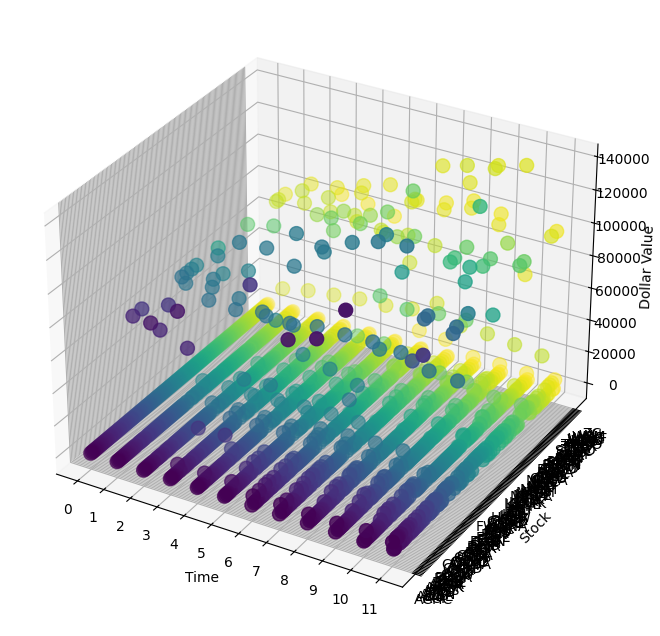

In [151]:

# Step 1: Rename the 'level' column in prices_df to 'price'
prices_df = prices_df.rename(columns={'value': 'price'})
print(prices_df)
# Step 2: Merge the two DataFrames on 'stocks' and 'time'
merged_df = pd.merge(df, prices_df, on=['stocks', 'time'], how='inner')
print(merged_df)
# Step 3: Calculate dollar value of each holding
merged_df['dollar_value'] = merged_df['level'] * merged_df['price']

# Step 4: Calculate total value of all stocks at each time period
merged_df['total_value'] = merged_df.groupby('time')['dollar_value'].transform('sum')

# Step 5: Calculate exposure of each stock
merged_df['exposure'] = merged_df['dollar_value'] / merged_df['total_value']

# Step 6: Replace NaN values in the 'exposure' column with 0
merged_df['exposure'] = merged_df['exposure'].fillna(0)

# Step 7: Identify the stock with the most exposure at each time period
most_exposed_stocks = merged_df.loc[merged_df.groupby('time')['exposure'].idxmax()]

# Print the stocks with the most exposure at each time period
print("Stocks with the most exposure at each time period:")
print(most_exposed_stocks[['stocks', 'time', 'exposure']])

# Step 1: Filter out stocks that were never bought (level always 0)
df_filtered = df.groupby('stocks').filter(lambda x: x['level'].max() > 0)

# Step 2: Merge the filtered holdings DataFrame with the prices DataFrame
merged_df = pd.merge(df_filtered, prices_df, on=['stocks', 'time'], how='inner')

# Step 3: Calculate the dollar value of each holding
merged_df['dollar_value'] = merged_df['level'] * merged_df['price']

# Step 4: Group by stocks and get the first and last dollar values for each stock
entry_exit_df = merged_df.groupby('stocks')['dollar_value'].agg(['first', 'last']).reset_index()

# Step 5: Define a tolerance for similarity
tolerance = 0.01  # 1% tolerance

# Step 6: Flag holdings where the first and last dollar values are the same or within tolerance
entry_exit_df['is_similar'] = abs(entry_exit_df['first'] - entry_exit_df['last']) <= (tolerance * entry_exit_df['first'])

# Step 7: Filter and display holdings with similar entry and exit values
similar_holdings = entry_exit_df[entry_exit_df['is_similar']]

print("Holdings with similar entry and exit values (excluding zero holdings):")
print(similar_holdings[['stocks', 'first', 'last']])


# Step 4: Filter out stocks that were never bought (level always 0)
merged_df_filtered = merged_df.groupby('stocks').filter(lambda x: x['level'].max() > 0)

# Step 5: Create a mapping from stock names to unique integers for the y-axis
stock_to_num = {stock: i for i, stock in enumerate(merged_df_filtered['stocks'].unique())}
merged_df_filtered['stock_num'] = merged_df_filtered['stocks'].map(stock_to_num)

# Step 6: Create the 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
ax.scatter(
    merged_df_filtered['time'], 
    merged_df_filtered['stock_num'], 
    merged_df_filtered['dollar_value'], 
    c=merged_df_filtered['stock_num'], 
    cmap='viridis', 
    s=100
)

# Label axes
ax.set_xlabel('Time')
ax.set_ylabel('Stock')
ax.set_zlabel('Dollar Value')

# Set y-axis ticks to show stock names
ax.set_yticks(list(stock_to_num.values()))
ax.set_yticklabels(list(stock_to_num.keys()))

# Show the plot
plt.show()

In [141]:
# Step 1: Filter out rows where level is 0 (inactive positions)
active_positions_df = df[df['level'] > 0]

# Step 2: Group by time and count the number of unique stocks
active_positions_count = active_positions_df.groupby('time')['stocks'].nunique().reset_index()
active_positions_count.columns = ['time', 'active_positions']

# Print the result
print("Number of active positions at each time period:")
print(active_positions_count)


Number of active positions at each time period:
   time  active_positions
0     0                 0
1     1                19
2     2                19
3     3                27
4     4                29
5     5                31
6     6                33
7     7                29
8     8                31
9     9                36
10   10                38
11   11               104


C:\Users\Sarang Sujit\AppData\Local\Temp\ipykernel_21596\2530615663.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  active_positions_count = active_positions_df.groupby('time')['stocks'].nunique().reset_index()


In [142]:
V.records

,time,level,marginal,lower,upper,scale
0,0,1.000000e+06,0.0,0.0,inf,1.0
1,1,9.902951e+05,0.0,0.0,inf,1.0
2,2,1.083315e+06,0.0,0.0,inf,1.0
3,3,1.083463e+06,0.0,0.0,inf,1.0
4,4,1.089163e+06,0.0,0.0,inf,1.0
5,5,1.108257e+06,0.0,0.0,inf,1.0
6,6,1.153583e+06,0.0,0.0,inf,1.0
7,7,1.184350e+06,0.0,0.0,inf,1.0
8,8,1.238138e+06,0.0,0.0,inf,1.0
9,9,1.277464e+06,0.0,0.0,inf,1.0


In [154]:
df = profit.records

# Filter out rows where 'level' is 0
non_zero_levels = df[df['level'] == 0]

# Find the lowest non-zero value in the 'level' column
lowest_non_zero = non_zero_levels['level'].count()

print("Lowest non-zero value in 'level':", lowest_non_zero)

Lowest non-zero value in 'level': 961


In [158]:
df = x.records


# Step 1: Filter out rows where level is 0 (inactive positions)
active_holdings_df = df[df['level'] > 0]

# Step 2: Count the number of unique stocks that were ever held
num_stocks_ever_held = active_holdings_df['stocks'].nunique()

print("Number of stocks ever held:", num_stocks_ever_held)

Number of stocks ever held: 150


In [159]:
profit.records

,stocks,level,marginal,lower,upper,scale
0,A,0.0,0.0,-inf,inf,1.0
1,AA,0.0,0.0,-inf,inf,1.0
2,AAL,0.0,0.0,-inf,inf,1.0
3,AAON,0.0,0.0,-inf,inf,1.0
4,AAP,0.0,0.0,-inf,inf,1.0
...,...,...,...,...,...,...
975,YUM,0.0,0.0,-inf,inf,1.0
976,Z,0.0,0.0,-inf,inf,1.0
977,ZBH,0.0,0.0,-inf,inf,1.0
978,ZBRA,0.0,0.0,-inf,inf,1.0
